In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sectionate
import xarray as xr
import numpy as np
import matplotlib.pylab as plt

# Creating a model OSNAP section with `sectionate`

In this example, we create an exact volume-conserving hydrographic section on the model grid that roughly follows the Overturning of the Subpolar North Atlantic (OSNAP) sections.

## 1. Symmetric grid example (CM2)

### Load the model grid

In [3]:
grid = xr.open_dataset('grid_CM2_minimal.nc')
symmetric = grid['geolon_c'].shape==grid['geolon_t'].shape
symmetric

True

### Define section start, end, and some intermediate points to capture the general structure

In [4]:
West_section_lats=[52.0166, 52.6648, 53.5577, 58.8944, 60.4000]
West_section_lons=[-56.8775, -52.0956, -49.8604, -47.6107, -44.8000]

We iterate on each linear segment of the section to better follow the path of the ship. We use `sectionate.create_section` to find the path of adjacent tracer cell indices that most closely follow each segment. The sub-sections for each linear segment are then appended to common arrays to build the full section.

**Note:** the last point of a segment is removed to not duplicate the first point of the following segment.



In [5]:
iwest = np.array([], dtype=np.int64)
jwest = np.array([], dtype=np.int64)
xwest = np.array([])
ywest = np.array([])
for k in range(len(West_section_lats)-1):
    isec, jsec, xsec, ysec = sectionate.create_section(grid['geolon_c'],
                                                       grid['geolat_c'],
                                                       West_section_lons[k], 
                                                       West_section_lats[k], 
                                                       West_section_lons[k+1],
                                                       West_section_lats[k+1])
    iwest = np.concatenate([iwest, isec[:-1]], axis=0)
    jwest = np.concatenate([jwest, jsec[:-1]], axis=0)
    xwest = np.concatenate([xwest, xsec[:-1]], axis=0)
    ywest = np.concatenate([ywest, ysec[:-1]], axis=0)

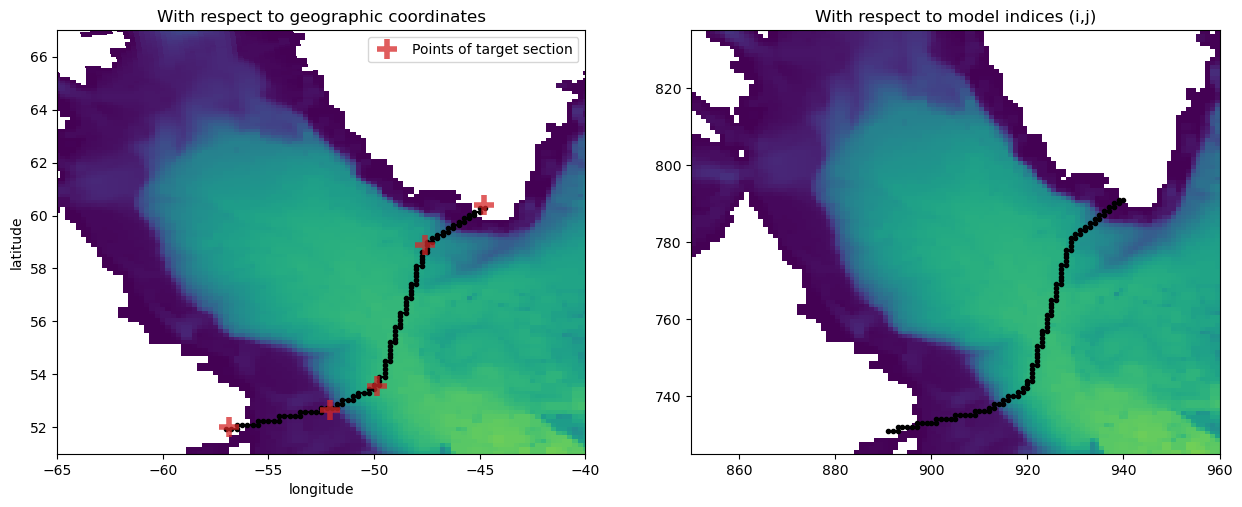

In [6]:
plt.figure(figsize=[15,5.5])
plt.subplot(1,2,1)
plt.pcolormesh(grid['geolon_t'], grid['geolat_t'], grid['ht'][1::,1::])
plt.plot(xwest, ywest, 'k.-')
plt.plot(West_section_lons, West_section_lats, "C3+", markersize=15., mew=4., alpha=0.75, label="Points of target section")
plt.axis([-65,-40, 51, 67])
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("With respect to geographic coordinates")
plt.legend(loc="upper right")

plt.subplot(1,2,2)
plt.pcolormesh(grid['ht'].values)
plt.plot(iwest, jwest, 'k.')
plt.axis([850,960, 725, 835])
plt.title("With respect to model indices (i,j)")
plt.show()

In [7]:
uvpoints = sectionate.transports_C.MOM6_UVpoints_from_section(iwest, jwest, symmetric=symmetric)

lons, lats = sectionate.transports_C.MOM6_UVcoords_from_points_hc(
    grid['geolon_t'],
    grid['geolat_t'],
    grid['geolon_c'],
    grid['geolat_c'],
    uvpoints,
    symmetric=symmetric,
    xh="xt_ocean",
    yh="yt_ocean",
    xq="xu_ocean",
    yq="yu_ocean"
)

#### Define an orientation such that transports are defined as positive if they are convergent in a counter-clockwise sense

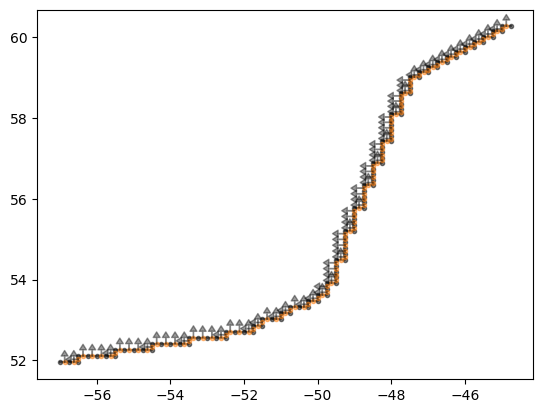

In [8]:
plt.plot(xwest, ywest, "ko-", alpha=0.5, markersize=3, label="tracer cell corners (vorticity grid)")
plt.plot(lons, lats, "C1o", alpha=0.5, lw=1, markersize=3, label="velocity cells (faces normal to section)")
for (p, (var, lon, lat, nward, eward)) in enumerate(zip(uvpoints['var'], lons, lats, uvpoints['nward'], uvpoints['eward'])):
    if var=="V":
        efact = 0.
        nfact = -1 if not(eward) else 1
    if var=="U":
        efact = -1 if nward else 1
        nfact = 0.

    plt.annotate('', xy=(lon+float(efact)*0.35, lat+float(nfact)*0.3),  xycoords='data',
            xytext=(lon, lat),
            arrowprops=dict(facecolor='black', shrink=0.01, width=0.25, headwidth=5., headlength=4., alpha=0.4),
            horizontalalignment='center', verticalalignment='center',
            )
    

## 2. Non-symmetric grid example (CM4)

### Load the model grid

In [9]:
dir_pp = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_test_v6_proto2/gfdl.ncrc4-intel18-prod-openmp/pp/'
grid = xr.open_dataset(f"{dir_pp}/ocean_annual_rho2_d2/ocean_annual_rho2_d2.static.nc")
symmetric = grid['geolon_c'].shape==grid['geolon'].shape
symmetric

False

### Define section start, end, and some intermediate points to capture the general structure

In [10]:
West_section_lats=[52.0166, 52.6648, 53.5577, 58.8944, 60.4000]
West_section_lons=[-56.8775, -52.0956, -49.8604, -47.6107, -44.8000]
East_section_lats=[60.3000, 58.8600, 58.0500, 58.0000, 56.5000]
East_section_lons=[-44.9000, -30.5400, -28.0000, -14.7000, -5.9300]

We iterate on each linear segment of the section to better follow the path of the ship. We use `sectionate.create_section` to find the path of adjacent tracer cell indices that most closely follow each segment. The sub-sections for each linear segment are then appended to common arrays to build the full section.

**Note:** the last point of a segment is removed to not duplicate the first point of the following segment.



In [11]:
iwest = np.array([], dtype=np.int64)
jwest = np.array([], dtype=np.int64)
xwest = np.array([])
ywest = np.array([])
for k in range(len(West_section_lats)-1):
    isec, jsec, xsec, ysec = sectionate.create_section(grid['geolon_c'],
                                                       grid['geolat_c'],
                                                       West_section_lons[k], 
                                                       West_section_lats[k], 
                                                       West_section_lons[k+1],
                                                       West_section_lats[k+1])
    iwest = np.concatenate([iwest, isec[:-1]], axis=0)
    jwest = np.concatenate([jwest, jsec[:-1]], axis=0)
    xwest = np.concatenate([xwest, xsec[:-1]], axis=0)
    ywest = np.concatenate([ywest, ysec[:-1]], axis=0)

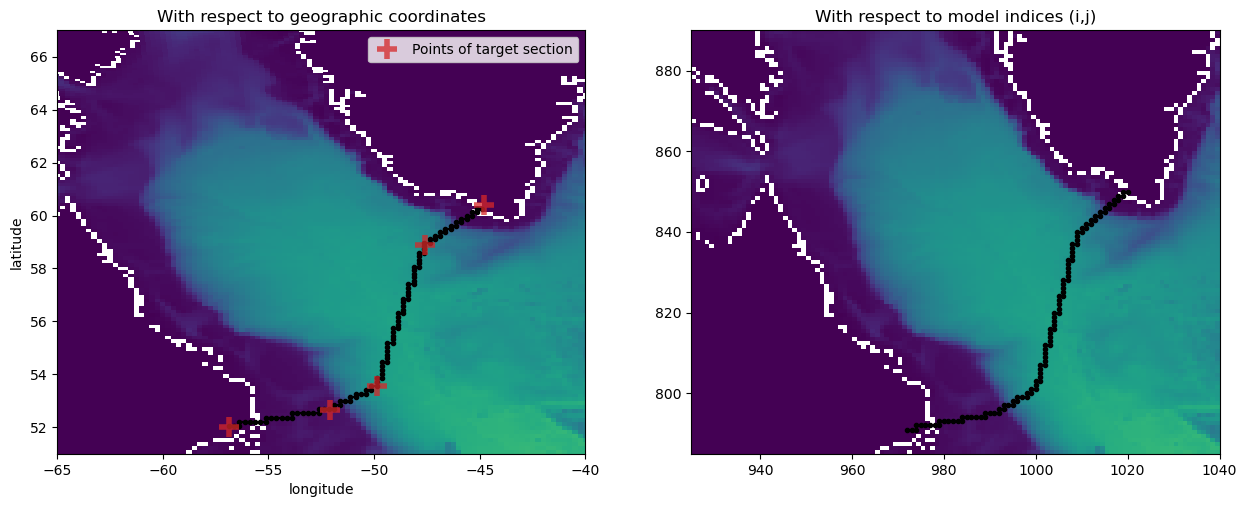

In [12]:
plt.figure(figsize=[15,5.5])
plt.subplot(1,2,1)
plt.pcolormesh(grid['geolon_c'], grid['geolat_c'], grid['deptho'])
plt.plot(xwest, ywest, 'k.-')
plt.plot(West_section_lons, West_section_lats, "C3+", markersize=15., mew=4., alpha=0.75, label="Points of target section")
plt.axis([-65,-40, 51, 67])
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("With respect to geographic coordinates")
plt.legend(loc="upper right")

plt.subplot(1,2,2)
plt.pcolormesh(grid['deptho'].values)
plt.plot(iwest, jwest, 'k.')
plt.axis([925, 1040, 785, 890])
plt.title("With respect to model indices (i,j)")
plt.show()

In [13]:
uvpoints = sectionate.transports_C.MOM6_UVpoints_from_section(iwest, jwest, symmetric=symmetric)
lons, lats = sectionate.transports_C.MOM6_UVcoords_from_points_uv(
    grid['geolon_u'],
    grid['geolat_u'],
    grid['geolon_v'],
    grid['geolat_v'],
    uvpoints,
    symmetric=symmetric,
)

#### Define an orientation such that transports are defined as positive if they are convergent in a counter-clockwise sense

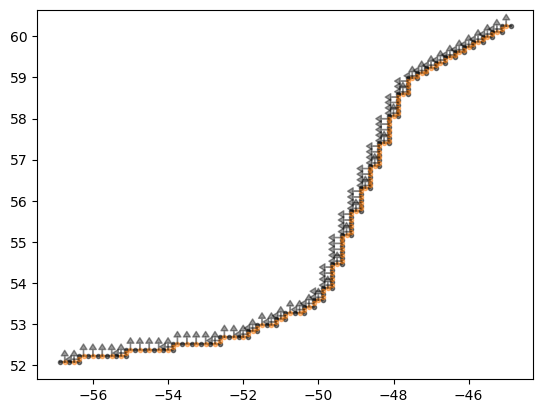

In [14]:
plt.plot(xwest, ywest, "ko-", alpha=0.5, markersize=3, label="tracer cell corners (vorticity grid)")
plt.plot(lons, lats, "C1o", alpha=0.5, lw=1, markersize=3, label="velocity cells (faces normal to section)")
for (p, (var, lon, lat, nward, eward)) in enumerate(zip(uvpoints['var'], lons, lats, uvpoints['nward'], uvpoints['eward'])):
    if var=="V":
        efact = 0.
        nfact = -1 if not(eward) else 1
    if var=="U":
        efact = -1 if nward else 1
        nfact = 0.

    plt.annotate('', xy=(lon+float(efact)*0.35, lat+float(nfact)*0.3),  xycoords='data',
            xytext=(lon, lat),
            arrowprops=dict(facecolor='black', shrink=0.01, width=0.25, headwidth=5., headlength=4., alpha=0.4),
            horizontalalignment='center', verticalalignment='center',
            )